# **Mount**

Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Setup

We setup the path of the ids and features numpy,saved at the end of the features extraction

In [ ]:
import numpy as np

ids_path = '/content/gdrive/MyDrive/progetto/pickles/image_ids.npy'
features_path = '/content/gdrive/MyDrive/progetto/pickles/image_features.npy'
labels_path = '/content/gdrive/MyDrive/progetto/pickles/image_labels.npy'

In [ ]:
'''
# Unzipping dataset
%cd '/content/gdrive/MyDrive/progetto/dbs/' 
!unzip -q total_dbs.zip
'''

"\n# Unzipping dataset\n%cd '/content/gdrive/MyDrive/progetto/dbs/' \n!unzip -q total_dbs.zip\n"

# **Load dataset**

Load the numpy files

In [ ]:
!ls /content/gdrive -all

total 20
dr-x------  2 root root 4096 Feb  3 21:29 .file-revisions-by-id
drwx------ 10 root root 4096 Feb  3 21:29 MyDrive
drwx------  2 root root 4096 Feb  3 21:29 Shareddrives
dr-x------  3 root root 4096 Feb  3 21:29 .shortcut-targets-by-id
drwx------  2 root root 4096 Feb  3 21:29 .Trash


In [ ]:
numpy_ids = np.load(ids_path)
numpy_features = np.load(features_path)
numpy_labels = np.load(labels_path)

mean =  np.mean(numpy_features,axis=0)
std = np.std(numpy_features,axis=0)

In [ ]:
class Image:

  def __init__(self,id,features, label = -2):
    self.id = id
    self.features = features
    self.label = label
  
  def get_id(self):
    return self.id
  
  def get_label(self):
    return self.label
  
  def get_features(self):
    return self.features

# **Hash Function**

HashFunction is the structure implementing a g function.
Its parameters are:

1. k = number of sub-hash functions
2. X[i] = hyperplane correspondig to the i-sub-hash function
3. d = len(X[i])
4. w = size of the segment = 4
5. b[i] = offset of the i-segment
6. m = mean of the Gaussian for extracting the planes
7. s = std of the Gaussian for extracting the planes


In [ ]:
class HashFunction:

  def __init__(self, k, d, m, s, w = 4 ):
    self.k = k
    self.m = m
    self.d = d
    self.s = s
    self.w = w

    self.b = []
    self.X = []
    for i in range(k):
      self.b.append( np.random.uniform(0, w))
    self.X = np.array([np.random.normal(loc=m[i],scale=s[i],size=k) for i in range(d)])
    self.X = np.transpose(self.X)
    
  def hash(self, value, i):
    return int( (np.dot(self.X[i], value) + self.b[i])/self.w )

  def index( self, value ):
    if( len( value ) != self.d  ):
      return False
    return "".join([str(self.hash(value,i)) for i in range(self.k)])

# **Hash Table**

We will create each hash table as a dictionary. Each line of the table will have all the ids of the image whose features share the projection on the same hyperplane.
We will have as many hash table as the number of g function we want to be implemented
Each HashTable has its own g function used to obtain the hash key

In [ ]:
class HashTable:

  def __init__(self,hash_size,input_dim,mean,std):
    self.table = dict()
    self.g_function = HashFunction(hash_size,input_dim,mean,std)
  
  def add_value(self, id, features, label = -1):
    hash_key = self.g_function.index(features)
    image = Image(id,features, label)
    if hash_key not in self.table:
      self.table[ hash_key ] = []
    self.table[ hash_key ].append(image)
  
  def inspect(self):
    print( self.table.keys() )
    print( self.table.values() )
  
  def get_values_of_key(self, features):
    hash_key = self.g_function.index(features)
    value_list = []
    if hash_key not in self.table:
      return False
    else:
      return self.table[ hash_key ]
  

# **LSHash**

LSHash is the structure implementing the lsh index.
Its parameters are:

1.   hash_size: number of the hyperplane implementing each g function
2.   num_hash_tables: number of g function, and consequently hash tables
3.   input_dim: dimension of the features(and of the vector representing each hyperplane)



In [ ]:
from numpy import dot
from numpy.linalg import norm
import math

class LSHash:
  def __init__(self,num_g_functions,input_dim,hash_size,mean,std, distance = "euclidean"):

    self.hash_size = hash_size
    self.num_g_functions = num_g_functions
    self.input_dim = input_dim #128
    self.init_hash_tables(hash_size,input_dim,mean,std)
    self.distance = distance
  
  #hash_tables will contain the HashTable mapped by each g function
  def init_hash_tables(self,hash_size,input_dim,mean,std):
    self.hash_tables = [HashTable(hash_size,input_dim,mean,std) for _ in range(self.num_g_functions)]
  
  # We insert the id of the image into the the line of the hash table whose line number corresponds to the id of the hyperplane
  # on which the projection of the vector of the features is the closest
  def insert_features(self,id,features, label = -3):
    for i in range(self.num_g_functions):
      self.hash_tables[i].add_value( id, features, label)

  def eval_distance(self, actual_features, target_feature):
    if(self.distance == "euclidean"):
      return np.linalg.norm(actual_features - target_feature)
    elif( self.distance == "cosine"):
      return (norm(actual_features)*norm(target_feature))/dot(actual_features,target_feature)
    else:
      return -1
  
  #We find the ids of the images that share the for each g function, all the time, the same hashed key of the features of the image
  def search(self,features):

    hash_lists = []
    hash_distance = []

    # for each hash table we retrieve the id of the images that share the same hyperplane of the features that we are projecting
    for i in range(self.num_g_functions):
      bucket = self.hash_tables[i].get_values_of_key(features)

      for b in bucket:
        element = [b.get_id(),b.get_label()]
        try:
           hash_lists.index( element ) # controlliamo che l'elemento non sia già in lista
        except ValueError:
          hash_lists.append( element ) # se non lo è si solleva l'eccezione e si aggiunge
          hash_distance.append( self.eval_distance(features, b.get_features()) ) # si calcola la distanza tra le due 

    zipped_ids = zip(hash_distance, hash_lists)
    sorted_zipped_lists = sorted(zipped_ids,reverse=False)

    return sorted_zipped_lists
    
  def get_hashTable(self,num):
    return self.hash_tables[num]


  def vote_label( sorted_zipped_list, voting_type = "majority" ):  
    labels_dict = {
      "0": [],
      "1": [],
      "2": [],
      "3": [],
      "4": [],
      "5": [],
      "6": []
    } 

    for distance, hash in sorted_zipped_list:
      label = str(hash[1])
      labels_dict[ label ].append( distance )
    
    win_label = -1
    if voting_type == "log_score":
      max_score = math.inf 
      for i in range(6):
        tmp_max_score = 0
        for j in range( len( labels_dict[str(i) ] ) ):
          tmp_max_score += 1 + math.log( labels_dict[str(i)][j] + np.finfo(float).eps, 10) 

        if tmp_max_score < max_score:
          win_label = i 
          max_score = tmp_max_score

    if voting_type == "majority":
      max_score = - math.inf 
      for i in range(6):
        tmp_max_score = len( labels_dict[str(i) ] )
        if tmp_max_score > max_score:
          win_label = i 
          max_score = tmp_max_score
        elif tmp_max_score == max_score and labels_dict[str(win_label)][0] > labels_dict[str(i)][0]:
          win_label = i

    return win_label 


In [ ]:
import math

def vote_label( sorted_zipped_list, voting_type = "majority" ):  
  labels_dict = {
    "0": [],
    "1": [],
    "2": [],
    "3": [],
    "4": [],
    "5": [],
    "6": []
  } 

  for distance, hash in sorted_zipped_list:
    label = str(hash[1])
    labels_dict[ label ].append( distance )
  
  win_label = -1
  if voting_type == "log_score":
    max_score = math.inf 
    for i in range(6):
      tmp_max_score = 0
      for j in range( len( labels_dict[str(i) ] ) ):
        tmp_max_score += 1 + math.log( labels_dict[str(i)][j] + np.finfo(float).eps, 10) 

      if tmp_max_score < max_score:
        win_label = i 
        max_score = tmp_max_score

  if voting_type == "majority":
    max_score = - math.inf 
    for i in range(6):
      tmp_max_score = len( labels_dict[str(i) ] )
      if tmp_max_score > max_score:
        win_label = i 
        max_score = tmp_max_score
      elif tmp_max_score == max_score and labels_dict[str(win_label)][0] > labels_dict[str(i)][0]:
        win_label = i

  return win_label 




In [ ]:
LSHashIndex = LSHash(8,128,16,mean,std, "cosine")
for i in range(len(numpy_features)):
  actual_feat = numpy_features[i]
  actual_id = numpy_ids[i]
  actual_label = numpy_labels[i]
  LSHashIndex.insert_features(actual_id,actual_feat,actual_label)

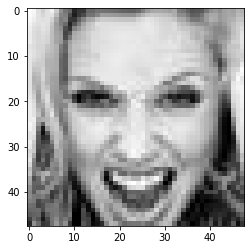

Num results: 1
[(0.99999994, ['10017.jpg', 0])]


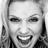

la label predetta è:
0


In [ ]:
import PIL
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def visualize_results(results):
  images = []
  counter = 0
  print("Num results: "+str(len(results)))
  print(results)
  for result in results:
    image_path = directory_path + result[1][0]
    if counter == 25:
      counter = 0
      sample_images = np.hstack(images[:25])  # stack 25 images horizontally
      sample_images = sample_images.astype(np.uint8)  # PIL wants uint8
      sample_images = PIL.Image.fromarray(sample_images)  # to PIL image
      display(sample_images) # show it
      images = []  
    images.append(np.asarray(mpimg.imread(image_path)))
    counter += 1

  sample_images = np.hstack(images)  # stack 5 images horizontally
  sample_images = sample_images.astype(np.uint8)  # PIL wants uint8
  sample_images = PIL.Image.fromarray(sample_images)  # to PIL image
  display(sample_images) # show it

directory_path = '/content/gdrive/MyDrive/progetto/dbs/total_dbs/' 
features_0 = numpy_features[2]
results = LSHashIndex.search(features_0)



# second_results = LSHashIndex.other_search(features_0)
# counter = 0
img = mpimg.imread(directory_path + numpy_ids[2])
imgplot = plt.imshow(img)
plt.show()
visualize_results(results)
print("la label predetta è:")
print( LSHash.vote_label(results, "majority" ))
#visualize_results(second_results)


In [ ]:

pick_path = '/content/gdrive/MyDrive/progetto/pickles/lsh_models'

cosine = "/cosine_similarity/"
eucl = "/euclidean_distance/"

for i in [4, 8, 16, 24]:
    for j in [4, 8, 16, 24]:
      LSHashIndex1 = LSHash(i,128, j,mean,std, "cosine")
      LSHashIndex2 = LSHash(i,128, j,mean,std)

      np.save( pick_path + cosine + "g_f=" + str(i) + "_h_f=" + str(j) + ".npy", LSHashIndex1)
      np.save( pick_path + eucl + "g_f=" + str(i) + "_h_f=" + str(j) + ".npy", LSHashIndex2)